In [0]:
import pandas as pd
import torch
import numpy as np
import math
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score
from torch import nn, optim

# Данные для обучения/тестирования методов
wine_url = "https://nagornyy.me/datasets/wine_reviews.csv.zip"
df_wine = pd.read_csv(wine_url)
# удаляем вина без рейтинга или без цены
df_wine.dropna(subset=["points", "price"], inplace=True)
df_wine.shape

y = torch.from_numpy((df_wine.points.values).reshape(-1, 1)).float()
X = torch.from_numpy((np.log(df_wine.price.values)).reshape(-1, 1)).float()

In [0]:
# Разделяем выборку на тренировочную и тестовую
y_train = y[:17000]
X_train = X[:17000]

In [0]:
# Общие параметры
learning_rate = 0.01
epochs = 500
momentum = 1e-3

loss_function_MSE = nn.MSELoss() 
def loss_function_R2(predicted, true):
  mean = (true.sum()) / true.numel()
  return ((((predicted - true) ** 2).sum())/(((true - mean) ** 2).sum())) - 1


In [0]:
# Обычный градиентый спуск
# MSE и R2
def model_grad_mse(X, w, b):
    return X @ w.t() + b
def model_grad_r2(X, w, b):
    return X @ w.t() + b

# История функции потерь от итерации
loss_history_model_grad_mse = []
loss_history_model_grad_r2 = []

# Веса и смещения
weight_mse = torch.randn(y_train.shape[1], X_train.shape[1])
bias_mse = torch.zeros(y_train.shape[1])
weight_mse.requires_grad_(True)
bias_mse.requires_grad_(True)

weight_r2 = torch.randn(y_train.shape[1], X_train.shape[1])
bias_r2 = torch.zeros(y_train.shape[1])
weight_r2.requires_grad_(True)
bias_r2.requires_grad_(True)

for epoch in range(epochs):
    # предсказания
    predictions_mse = model_grad_mse(X_train, weight_mse, bias_mse)
    predictions_r2 = model_grad_r2(X_train, weight_r2, bias_r2)
    # ошибка
    loss_mse = loss_function_MSE(predictions_mse, y_train)
    loss_r2 = loss_function_R2(predictions_r2, y_train)
    # запоминаем ошибки
    loss_history_model_grad_mse.append(loss_mse.item())
    loss_history_model_grad_r2.append(loss_r2.item())
    # вычисляем градиент
    loss_mse.backward()
    loss_r2.backward()
    # вычитаем производные из параметров
    # записывать историю вычислений
    with torch.no_grad():
        weight_mse -= weight_mse.grad * learning_rate
        bias_mse -= bias_mse.grad * learning_rate
        weight_r2 -= weight_r2.grad * learning_rate
        bias_r2 -= bias_r2.grad * learning_rate
        # обнуляем производные
        weight_mse.grad.zero_()
        bias_mse.grad.zero_()
        weight_r2.grad.zero_()
        bias_r2.grad.zero_()
    # выводим значение фукнции потерь
    if (epoch + 1) % (epochs / 10) == 0:
        print('MSE epoch {}, loss {}'.format(epoch, loss_mse.item()))
        print('R2 epoch {}, loss {}'.format(epoch, loss_r2.item()))

MSE epoch 49, loss 191.02503967285156
R2 epoch 49, loss 103.96142578125
MSE epoch 99, loss 177.85623168945312
R2 epoch 99, loss 27.036195755004883
MSE epoch 149, loss 165.6277618408203
R2 epoch 149, loss 19.155696868896484
MSE epoch 199, loss 154.27224731445312
R2 epoch 199, loss 18.24285125732422
MSE epoch 249, loss 143.7275390625
R2 epoch 249, loss 18.033859252929688
MSE epoch 299, loss 133.9355926513672
R2 epoch 299, loss 17.896713256835938
MSE epoch 349, loss 124.84282684326172
R2 epoch 349, loss 17.767635345458984
MSE epoch 399, loss 116.39924621582031
R2 epoch 399, loss 17.640165328979492
MSE epoch 449, loss 108.5584945678711
R2 epoch 449, loss 17.51367950439453
MSE epoch 499, loss 101.27755737304688
R2 epoch 499, loss 17.38808250427246


In [0]:
class LinearRegression(nn.Module):
    def __init__(self):
        super(LinearRegression, self).__init__()
        self.linear = nn.Linear(1, 1)

    def forward(self, X):
        predictions = self.linear(X)
        return predictions

# Стохастический градиентный спуск
# MSE и R2
model_sgd_mse = LinearRegression()
model_sgd_r2 = LinearRegression()

optimizer_mse = optim.SGD(model_sgd_mse.parameters(), lr=learning_rate)
optimizer_r2 = optim.SGD(model_sgd_r2.parameters(), lr=learning_rate)

# История функции потерь от итерации
loss_history_model_sgd_mse = []
loss_history_model_sgd_r2 = []

for epoch in range(epochs):
    optimizer_mse.zero_grad()
    optimizer_r2.zero_grad()
    #  предсказания
    predictions_mse = model_sgd_mse(X_train)
    predictions_r2 = model_sgd_r2(X_train)
    # ошибка  loss_function_MSE
    loss_mse = loss_function_MSE(predictions_mse, y_train)
    loss_r2 = loss_function_R2(predictions_r2, y_train)
    # запоминаем ошибки
    loss_history_model_sgd_mse.append(loss_mse.item())
    loss_history_model_sgd_r2.append(loss_r2.item())
    # градиенты
    loss_mse.backward()
    loss_r2.backward()
    # шаг спуска
    optimizer_mse.step()
    optimizer_r2.step()
    
    if (epoch + 1) % (epochs / 10) == 0:
        print('MSE epoch {}, loss {}'.format(epoch, loss_mse.item()))
        print('R2 epoch {}, loss {}'.format(epoch, loss_r2.item()))


MSE epoch 49, loss 195.3499298095703
R2 epoch 49, loss 89.41761016845703
MSE epoch 99, loss 181.87234497070312
R2 epoch 99, loss 25.46084976196289
MSE epoch 149, loss 169.35708618164062
R2 epoch 149, loss 18.889677047729492
MSE epoch 199, loss 157.73536682128906
R2 epoch 199, loss 18.109670639038086
MSE epoch 249, loss 146.94338989257812
R2 epoch 249, loss 17.91483497619629
MSE epoch 299, loss 136.92190551757812
R2 epoch 299, loss 17.779870986938477
MSE epoch 349, loss 127.6159439086914
R2 epoch 349, loss 17.651735305786133
MSE epoch 399, loss 118.97439575195312
R2 epoch 399, loss 17.52510643005371
MSE epoch 449, loss 110.94969177246094
R2 epoch 449, loss 17.399431228637695
MSE epoch 499, loss 103.49800872802734
R2 epoch 499, loss 17.274625778198242


In [0]:
# Метод Momentum
# MSE и R2
model_momentum_mse = LinearRegression()
model_momentum_r2 = LinearRegression()

optimizer_mse = optim.SGD(model_momentum_mse.parameters(), lr=learning_rate, momentum=momentum)
optimizer_r2 = optim.SGD(model_momentum_r2.parameters(), lr=learning_rate, momentum=momentum)

# История функции потерь от итерации
loss_history_model_momentum_mse = []
loss_history_model_momentum_r2 = []

for epoch in range(epochs):
    optimizer_mse.zero_grad()
    optimizer_r2.zero_grad()
    #  предсказания
    predictions_mse = model_momentum_mse(X_train)
    predictions_r2 = model_momentum_r2(X_train)
    # ошибка  loss_function_MSE
    loss_mse = loss_function_MSE(predictions_mse, y_train)
    loss_r2 = loss_function_R2(predictions_r2, y_train)
    # запоминаем ошибки
    loss_history_model_momentum_mse.append(loss_mse.item())
    loss_history_model_momentum_r2.append(loss_r2.item())
    # градиенты
    loss_mse.backward()
    loss_r2.backward()
    # шаг спуска
    optimizer_mse.step()
    optimizer_r2.step()
    
    if (epoch + 1) % (epochs / 10) == 0:
        print('MSE epoch {}, loss {}'.format(epoch, loss_mse.item()))
        print('R2 epoch {}, loss {}'.format(epoch, loss_r2.item()))

MSE epoch 49, loss 190.9790802001953
R2 epoch 49, loss 99.67093658447266
MSE epoch 99, loss 177.80088806152344
R2 epoch 99, loss 26.96611213684082
MSE epoch 149, loss 165.56455993652344
R2 epoch 149, loss 19.52602195739746
MSE epoch 199, loss 154.20260620117188
R2 epoch 199, loss 18.65656089782715
MSE epoch 249, loss 143.65272521972656
R2 epoch 249, loss 18.449369430541992
MSE epoch 299, loss 133.85667419433594
R2 epoch 299, loss 18.309680938720703
MSE epoch 349, loss 124.76073455810547
R2 epoch 349, loss 18.177623748779297
MSE epoch 399, loss 116.31489562988281
R2 epoch 399, loss 18.047164916992188
MSE epoch 449, loss 108.47261810302734
R2 epoch 449, loss 17.917692184448242
MSE epoch 499, loss 101.1906967163086
R2 epoch 499, loss 17.78912925720215


Text(0, 0.5, 'loss value')

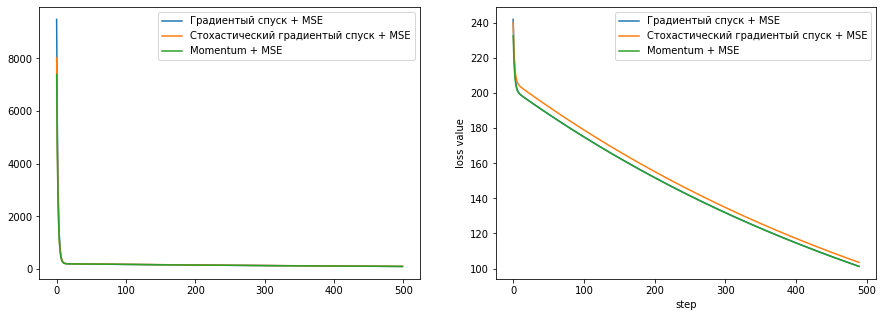

In [0]:
# График функции потерь по итерациям MSE
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
ax1.plot(loss_history_model_grad_mse, label="Градиентый спуск + MSE")
ax1.plot(loss_history_model_sgd_mse, label="Стохастический градиентый спуск + MSE")
ax1.plot(loss_history_model_momentum_mse, label="Momentum + MSE")
ax1.legend()
ax2.plot(loss_history_model_grad_mse[10:], label="Градиентый спуск + MSE")
ax2.plot(loss_history_model_sgd_mse[10:], label="Стохастический градиентый спуск + MSE")
ax2.plot(loss_history_model_momentum_mse[10:], label="Momentum + MSE")
ax2.legend()
plt.xlabel('step')
plt.ylabel('loss value')

Text(0, 0.5, 'loss value')

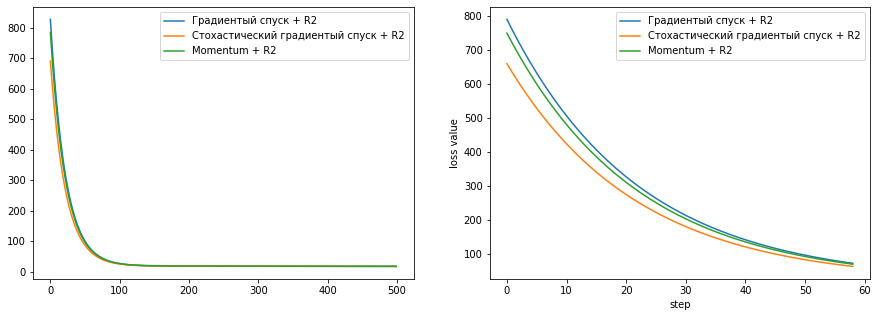

In [0]:
# График функции потерь по итерациям R2
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
ax1.plot(loss_history_model_grad_r2, label="Градиентый спуск + R2")
ax1.plot(loss_history_model_sgd_r2, label="Стохастический градиентый спуск + R2")
ax1.plot(loss_history_model_momentum_r2, label="Momentum + R2")
ax1.legend()
ax2.plot(loss_history_model_grad_r2[1:60], label="Градиентый спуск + R2")
ax2.plot(loss_history_model_sgd_r2[1:60], label="Стохастический градиентый спуск + R2")
ax2.plot(loss_history_model_momentum_r2[1:60], label="Momentum + R2")
ax2.legend()
plt.xlabel('step')
plt.ylabel('loss value')